<a href="https://colab.research.google.com/github/kassio077/Aprendizado-de-maquina/blob/master/Atividade4_Agrupamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Agrupamento

O Dataset consiste em informações de um ambiente simulado de ataques a uma LAN (Network de Área Local) Militar. A base de dados é composta por 42 atributos e 25192 instâncias que estão classificadas como:
1. anormaly

2. normal

Os atributos descrevem se uma conexão representa ou não um ataque de intruso a rede.

Link para o dataset: link text

# 1. Carregando os dados

In [33]:
from google.colab import drive

import numpy as np
import pandas as pd

dados = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Train_data.csv')
data_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Test_data.csv')



# 2. Limpeza e organização dos dados

* Alguns atributos não estão contribuindo para a classificação, pois estão com valores comuns para as instâncias. Por isso aplicamos a remoção de alguns deles.
* O atributo que representa a classificação foi transformado em numérico para ser utilizado em algumas técnicas de análise.
* O atributo **service** foi removido porque apresentava valores muito específicos para cada instância.

In [2]:
#Remoção dos atributos
dados = dados.drop(columns=['service','land','wrong_fragment','urgent','hot','num_failed_logins',
                            'num_compromised','root_shell','su_attempted','num_root',
                            'num_file_creations','num_shells','num_access_files',
                            'num_outbound_cmds','is_host_login','is_guest_login'])

#Transformando o atributo categorico em numérico.
dados['class'] = dados['class'].replace(['anomaly','normal'],[1,0])

dados['protocol_type'] = dados['protocol_type'].replace(['tcp','udp','icmp'],['1','2','3'])
dados['flag'] = dados['flag'].replace(['SF','S0','REJ','RSTR','SH','RSTO','S1','RSTOS0','S3','S2','OTH'],
                                      ['0001','0010','0100','1000','1111','0011','0110','0101','1100','1110','0111'])

# 3. Preparação dos dados para o agrupamento


 * Normalizando os atributos numéricos, através da re-escala usando máximo e mínimo.

In [3]:
dados['duration'] = dados['duration']/dados['duration'].max()

atributos_categoricos = dados.iloc[:,0:3]

#Dataframe apenas com as colunas de atributos numéricos.
atributos_numericos = dados.iloc[:,3:25] 
#Aplicando a re-escala.
atributos_numericos = (atributos_numericos - atributos_numericos.min())/(atributos_numericos.max()-atributos_numericos.min())

atributos_numericos.head(10)

,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1.286320e-06,0.000000,0.0,0.001961,0.001961,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,3.824902e-07,0.000000,0.0,0.023529,0.000000,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.000000e+00,0.000000,0.0,0.239216,0.009804,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,6.077927e-07,0.001583,1.0,0.007843,0.007843,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,5.213394e-07,0.000082,1.0,0.056863,0.060784,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.000000e+00,0.000000,0.0,0.235294,0.035294,0.0,0.0,1.0,1.0,0.16,0.06,0.00,1.000000,0.074510,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00
6,0.000000e+00,0.000000,0.0,0.323529,0.015686,1.0,1.0,0.0,0.0,0.05,0.06,0.00,1.000000,0.035294,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00
7,0.000000e+00,0.000000,0.0,0.227451,0.029412,1.0,1.0,0.0,0.0,0.14,0.06,0.00,1.000000,0.058824,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00
8,0.000000e+00,0.000000,0.0,0.527451,0.043137,1.0,1.0,0.0,0.0,0.09,0.05,0.00,1.000000,0.090196,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00
9,0.000000e+00,0.000000,0.0,0.258824,0.013725,1.0,1.0,0.0,0.0,0.06,0.06,0.00,1.000000,0.050980,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00


* Separando os atributos descritores do atributo de classe.

In [4]:
#Subconjunto dos atributos descritores
atributos_descritores = pd.merge(atributos_categoricos,atributos_numericos, left_index=True, right_index=True)
atributos_descritores.head(10)

,duration,protocol_type,flag,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1,0001,1.286320e-06,0.000000,0.0,0.001961,0.001961,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,2,0001,3.824902e-07,0.000000,0.0,0.023529,0.000000,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,1,0010,0.000000e+00,0.000000,0.0,0.239216,0.009804,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.0,1,0001,6.077927e-07,0.001583,1.0,0.007843,0.007843,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,1,0001,5.213394e-07,0.000082,1.0,0.056863,0.060784,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.0,1,0100,0.000000e+00,0.000000,0.0,0.235294,0.035294,0.0,0.0,1.0,1.0,0.16,0.06,0.00,1.000000,0.074510,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00
6,0.0,1,0010,0.000000e+00,0.000000,0.0,0.323529,0.015686,1.0,1.0,0.0,0.0,0.05,0.06,0.00,1.000000,0.035294,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00
7,0.0,1,0010,0.000000e+00,0.000000,0.0,0.227451,0.029412,1.0,1.0,0.0,0.0,0.14,0.06,0.00,1.000000,0.058824,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00
8,0.0,1,0010,0.000000e+00,0.000000,0.0,0.527451,0.043137,1.0,1.0,0.0,0.0,0.09,0.05,0.00,1.000000,0.090196,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00
9,0.0,1,0010,0.000000e+00,0.000000,0.0,0.258824,0.013725,1.0,1.0,0.0,0.0,0.06,0.06,0.00,1.000000,0.050980,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00


In [5]:
#Subconjunto do atributo class
atributo_classe = dados['class']
atributo_classe.head()

0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64

# 4. Definindo o modelo de Agrupamento

Para criação do modelo de agrupamento utilizamos o algoritmo k-means que um de seus passos é definir a quantidade de clusters. Como conhecemos o contexto do problema, em que as instâncias estão classificadas como anomaly e normal, vamos definir 2 grupos para de alguma forma representar este cenário.

* **Aplicando o algoritmo K-Means**





In [6]:
from sklearn.cluster import KMeans


atributos_descritores.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1,0001,1.286320e-06,0.000000,0.0,0.001961,0.001961,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,2,0001,3.824902e-07,0.000000,0.0,0.023529,0.000000,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,1,0010,0.000000e+00,0.000000,0.0,0.239216,0.009804,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.0,1,0001,6.077927e-07,0.001583,1.0,0.007843,0.007843,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,1,0001,5.213394e-07,0.000082,1.0,0.056863,0.060784,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [7]:
#modelo de agrupamento
kmeans = KMeans(n_clusters=2,max_iter=1000)
kmeans.fit(atributos_descritores)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

 Gerando os rótulos das instâncias definidos pelo modelo de agrupamento que representam os grupos aos quais elas pertencem, a partir do método predict. No grupo 0 estão as instâncias que estão relacionadas com alguma similaridade, o mesmo acontece no grupo 1:

In [8]:
#definindo os rotulos
kmeans_labels = kmeans.predict(atributos_descritores)
kmeans_labels



array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

* **Visualizando os resultados dos grupos**

In [9]:
import matplotlib.pyplot as plt

In [10]:
atributos_descritores = atributos_descritores.reset_index(drop=True)

In [11]:
# adicionando as labels atribuidas pelo agrupamento
grupos = pd.DataFrame(kmeans_labels)
atributos_descritores.insert((atributos_descritores.shape[1]),'class',grupos)

In [12]:
normal = atributos_descritores[atributos_descritores['class']==0]
anomaly = atributos_descritores[atributos_descritores['class']==1]

In [13]:
plt.rcParams["figure.figsize"] = (8,5)

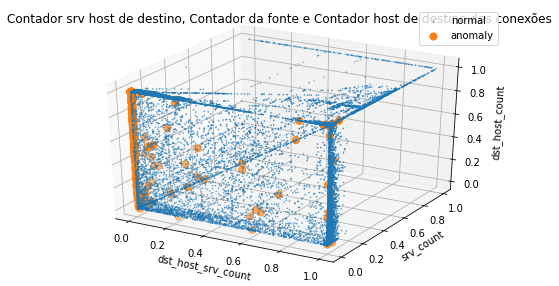

In [14]:
#plotando alguns atributos das classes
ax = plt.axes(projection='3d')
ax.scatter3D(normal.dst_host_srv_count,normal.srv_count,normal.dst_host_count,s=0.3,label='normal')
ax.scatter3D(anomaly.dst_host_srv_count,anomaly.srv_count,anomaly.dst_host_count,s=50,label='anomaly')
plt.legend()
ax.set_xlabel('dst_host_srv_count')
ax.set_ylabel('srv_count')
ax.set_zlabel('dst_host_count')
plt.title('Contador srv host de destino, Contador da fonte e Contador host de destino das conexões')
plt.show()

Com a plotagem do gráfico 3d, podemos perceber que as instâncias dos grupos segmentados pelo agrupamento ficaram dispersas, em relação aos atributos analisados. Além dos grupos que ficaram muito desbalanceados, como pode ser visto no histograma:


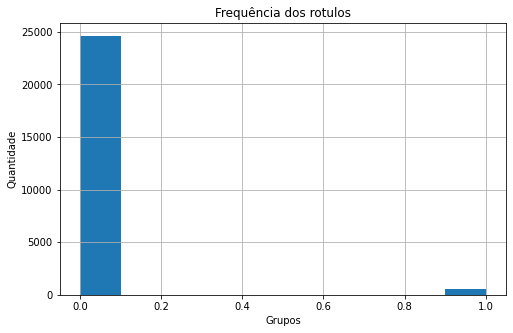

cluster 0:  24616
cluster 1:  576


In [15]:

import matplotlib.pyplot as plt

plt.hist(kmeans_labels)
plt.xlabel('Grupos')
plt.ylabel('Quantidade')
plt.title('Frequência dos rotulos')
plt.grid(True)
plt.show()

import collections

#quantidade de ocorrências de cada grupo
instancias_cluster0 = collections.Counter(kmeans_labels)
instancias_cluster1 = collections.Counter(kmeans_labels)
print('cluster 0: ',instancias_cluster0[0])
print('cluster 1: ', instancias_cluster1[1])

#5. Avaliando o modelo

Para avaliar o modelo utilizamos os valores reais das classes das intâncias, comparados aos atribuidos pelo agrupamento. Porém, não podemos afirmar se os rotulos atribuidos pelo modelo de agrupamento correspodem exatamente aos valores de classe originais.

 

 **Métrica com classes conhecidas**

 * Acúracia

 Se considerarmos como uma taxa de acerto ou seja os labels atribuídas pelo modelo coincidiu com os rótulos reais das instâncias, a taxa foi muito ruim. Assim como, se considerarmos que o modelo inverteu os rótulos das instâncias, o resultado representaria a taxa de erro do modelo.



In [16]:
from sklearn.metrics import accuracy_score
acuracia = accuracy_score(atributo_classe,kmeans_labels)
round(acuracia,3)

0.552

* Índice Rand Ajustado

 Se ignorarmos as permutações dos rótulos pelo modelo, o Índice Rand Ajustado calculou uma taxa ainda pior que a acurácia.

In [17]:
from sklearn.metrics import adjusted_rand_score

In [18]:
rand_score = adjusted_rand_score(atributo_classe,kmeans_labels)
rand_score

0.006647858909587756

In [19]:
atributos_descritores.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,1,0001,1.286320e-06,0.000000,0.0,0.001961,0.001961,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0.0,2,0001,3.824902e-07,0.000000,0.0,0.023529,0.000000,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0.0,1,0010,0.000000e+00,0.000000,0.0,0.239216,0.009804,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0.0,1,0001,6.077927e-07,0.001583,1.0,0.007843,0.007843,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0.0,1,0001,5.213394e-07,0.000082,1.0,0.056863,0.060784,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


**Métricas com classes não conhecidas**

* Índice Davies-Boldin

 O resultado a partir desta métrica aponta uma proximidade entre os centroides dos dois grupos, e disimilaridade das intâncias em relação ao centroide do cluster que pertecem, pois, seu valor esta próximo de 0.


In [20]:
#excluindo a coluna class
atributos_descritores = atributos_descritores.drop(columns=['class'])

In [21]:
from sklearn.metrics import davies_bouldin_score

In [22]:
#score Davies-Boldin
db = davies_bouldin_score(atributos_descritores,kmeans_labels)
db

0.04240310063147263

 *  Coeficiente de Silhueta
 
 Em contrapartida a métrica anterior, a taxa do coeficiente de silhueta apresentou um bom resultado, indica que os clusters estão bem separados.

In [23]:
from sklearn.metrics import silhouette_score

In [24]:
ss = silhouette_score(atributos_descritores,kmeans_labels,metric='euclidean')
ss

0.9786466202235786

# 6. Agrupamento hierárquico

Para fins de comparação realizamos o agrupamento hierárquico. A avaliação do modelo gerado foi idêntica a do k-means.

In [27]:
from sklearn.cluster import AgglomerativeClustering

In [28]:
hierarquico = AgglomerativeClustering(n_clusters=2)
labels_hierarquico = hierarquico.fit(atributos_descritores).labels_

In [29]:
labels_hierarquico

array([0, 0, 0, ..., 0, 0, 0])

 **Avaliando o modelo**

In [30]:
#acurácia
acuracia = accuracy_score(atributo_classe,labels_hierarquico)
round(acuracia,3)

0.552